In [3]:
# Import packages
import xarray as xr
import numpy as np

## Load in the necessary python packages to train a neural network

import tensorflow.keras as keras
import tensorflow as tf

In [4]:
try:
    !wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/geopotential_500_5.625deg.zip
except:
    !wget --no-check-certificate "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Fgeopotential_500&files=geopotential_500_5.625deg.zip" -O geopotential_500_5.625deg.zip

--2024-11-18 09:22:35--  https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/geopotential_500_5.625deg.zip
Resolving get.ecmwf.int (get.ecmwf.int)... 136.156.238.204
Connecting to get.ecmwf.int (get.ecmwf.int)|136.156.238.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1532774663 (1.4G) [application/zip]
Saving to: 'geopotential_500_5.625deg.zip'

geopotential_500_5. 100%[===================>]   1.43G  6.65MB/s    in 5m 37s  

2024-11-18 09:28:13 (4.34 MB/s) - 'geopotential_500_5.625deg.zip' saved [1532774663/1532774663]



In [5]:
# Unzip the data
!unzip geopotential_500_5.625deg.zip

Archive:  geopotential_500_5.625deg.zip
  inflating: geopotential_500hPa_1979_5.625deg.nc  
  inflating: geopotential_500hPa_1980_5.625deg.nc  
  inflating: geopotential_500hPa_1981_5.625deg.nc  
  inflating: geopotential_500hPa_1982_5.625deg.nc  
  inflating: geopotential_500hPa_1983_5.625deg.nc  
  inflating: geopotential_500hPa_1984_5.625deg.nc  
  inflating: geopotential_500hPa_1985_5.625deg.nc  
  inflating: geopotential_500hPa_1986_5.625deg.nc  
  inflating: geopotential_500hPa_1987_5.625deg.nc  
  inflating: geopotential_500hPa_1988_5.625deg.nc  
  inflating: geopotential_500hPa_1989_5.625deg.nc  
  inflating: geopotential_500hPa_1990_5.625deg.nc  
  inflating: geopotential_500hPa_1991_5.625deg.nc  
  inflating: geopotential_500hPa_1992_5.625deg.nc  
  inflating: geopotential_500hPa_1993_5.625deg.nc  
  inflating: geopotential_500hPa_1994_5.625deg.nc  
  inflating: geopotential_500hPa_1995_5.625deg.nc  
  inflating: geopotential_500hPa_1996_5.625deg.nc  
  inflating: geopotentia

In [6]:
z500 = xr.open_mfdataset('geopotential_500*.nc', combine='by_coords').isel(time=slice(None, None, 12))
z500

<xarray.Dataset> Size: 240MB
Dimensions:  (time: 29220, lat: 32, lon: 64)
Coordinates:
    level    int32 4B 500
  * lon      (lon) float64 512B 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lat      (lat) float64 256B -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 234kB 1979-01-01 ... 2018-12-31T12:00:00
Data variables:
    z        (time, lat, lon) float32 239MB dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [7]:
# Now we can load the data into memory to speed up accessing data. This should take <30s
z500.load()

<xarray.Dataset> Size: 240MB
Dimensions:  (time: 29220, lat: 32, lon: 64)
Coordinates:
    level    int32 4B 500
  * lon      (lon) float64 512B 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lat      (lat) float64 256B -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 234kB 1979-01-01 ... 2018-12-31T12:00:00
Data variables:
    z        (time, lat, lon) float32 239MB 5.156e+04 5.158e+04 ... 4.864e+04
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

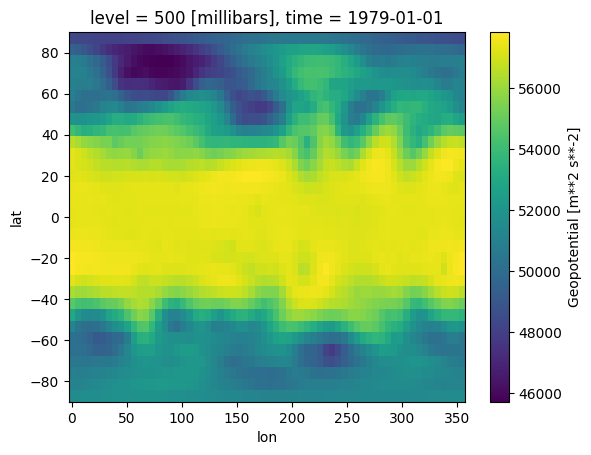

In [8]:
# Plot the geopotential at an example date-time
z500.z.isel(time=0).plot();

In [13]:
# training dataset selection
train_years = slice('1979', '2015')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('2016', '2016')
# test dataset selection
test_years = slice('2017', '2018')

In [14]:
def computed_weighted_rmse(fc, gt):
  """Error metric to compute the area averaged RMSE."""
  error = fc - gt
  weights_lat = np.cos(np.deg2rad(error.lat))
  weights_lat /= weights_lat.mean()
  rmse = np.sqrt(((error)**2 * weights_lat).mean(('time', 'lat', 'lon')))
  return rmse

In [15]:
# pick the forecast lead time
lead_time_steps = 10 # 5 day forecast because considering midday and midnight

# compute persistent forecast 
persistence_fc = z500.sel(time=test_years).isel(time=slice(0, -lead_time_steps))
persistence_fc['time'] = persistence_fc.time + np.timedelta64(5, 'D').astype('timedelta64[ns]')

# target data
target = z500.sel(time=test_years)['z']
# compute RMSE
computed_weighted_rmse(persistence_fc, target)

<xarray.Dataset> Size: 12B
Dimensions:  ()
Coordinates:
    level    int32 4B 500
Data variables:
    z        float64 8B 1.034e+03

In [16]:
clim = z500.sel(time=train_years).groupby('time.dayofyear').mean()
# compute RMSE
computed_weighted_rmse(clim.sel(dayofyear=z500.sel(time=test_years).time.dt.dayofyear), z500)

<xarray.Dataset> Size: 12B
Dimensions:  ()
Coordinates:
    level    int32 4B 500
Data variables:
    z        float64 8B 819.9

In [18]:
def get_train_valid_test_dataset(lead_steps, z500_dataset):
  # Split train, valid and test dataset
  train_data = z500_dataset.sel(time=train_years)
  valid_data = z500_dataset.sel(time=valid_years)
  test_data = z500_dataset.sel(time=test_years)

  # Normalize the data using the mean and standard deviation of the training data
  mean = train_data.mean()
  std = train_data.std()

  train_data = (train_data - mean) / std
  valid_data = (valid_data - mean) / std
  test_data = (test_data - mean) / std

  mean = mean['z'].values # extract numerical value from xarray Dataset
  std = std['z'].values # extract numerical value from xarray Dataset

  # Create inputs and outputs that are shifted by lead_steps
  X_train = train_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_train = train_data.z.isel(time=slice(lead_steps, None)).values[..., None]
  X_valid = valid_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_valid = valid_data.z.isel(time=slice(lead_steps, None)).values[..., None]  
  X_test = test_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_test = test_data.z.isel(time=slice(lead_steps, None)).values[..., None]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

In [19]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, z500)
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(27018, 32, 64, 1)
(27018, 32, 64, 1)
(722, 32, 64, 1)
(722, 32, 64, 1)
(1450, 32, 64, 1)
(1450, 32, 64, 1)


In [21]:
# CNN

model = keras.Sequential([
    keras.layers.Conv2D(32, 5, padding='same'),   # 32 channels with a 5x5 convolution
    keras.layers.ELU(),  # Slightly smoother alternative to ReLU
    keras.layers.Conv2D(32, 5, padding='same'),   # Same padding keeps the size identical.
    keras.layers.ELU(),
    keras.layers.Conv2D(1, 5, padding='same'),
    # No activation since we are solving a regression problem
])

In [22]:
model.build(X_train[:32].shape)
model.compile(keras.optimizers.Adam(1e-4), 'mse')

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (32, 32, 64, 32)       │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_2 (ELU)                     │ (32, 32, 64, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 32, 64, 32)       │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_3 (ELU)                     │ (32, 32, 64, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 32, 64, 1)        │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,265 (106.50 KB)

 Trainable params: 27,265 (106.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Finally we can fit the model.
# For each epoch, the entire training dataset has passed through the neural network exactly once
# Each epoch should take about 10s

model.fit(X_train, Y_train, batch_size=32, epochs=15)

Epoch 1/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 221s 260ms/step - loss: 0.1350
Epoch 2/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 215s 254ms/step - loss: 0.0870
Epoch 3/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 209s 248ms/step - loss: 0.0860
Epoch 4/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 214s 253ms/step - loss: 0.0854
Epoch 5/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 217s 257ms/step - loss: 0.0849
Epoch 6/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 258s 253ms/step - loss: 0.0844
Epoch 7/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 210s 248ms/step - loss: 0.0841
Epoch 8/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 208s 246ms/step - loss: 0.0839
Epoch 9/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 266s 251ms/step - loss: 0.0838
Epoch 10/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 210s 249ms/step - loss: 0.0835
Epoch 11/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 256s 242ms/step - loss: 0.0833
Epoch 12/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 214s 253ms/step - loss: 0.0834
Epoch 13/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 211s 249ms/step - loss: 0.0831
Epoch 14/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 207s 245ms/step - loss: 0.0830
E

In [26]:
# Convert predictions backto xarray
pred_test = X_test[:, :, :, 0].copy()
pred_test[:] = model.predict(X_test).squeeze()   # To remove channel dimension which is 1

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


In [29]:
# Unnormalize
pred_test = pred_test * std + mean
# compute RMSE
computed_weighted_rmse(pred_test, target.isel(time=slice(lead_time_steps, None)))

<xarray.DataArray ()> Size: 8B
array(6.24353681e+11)
Coordinates:
    level    int32 4B 500

/tmp/ipykernel_30/2304207596.py:11: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  t = xr.DataArray(np.datetime64('2017-10-01T00'))


Text(0.5, 1.0, 'Prediction')

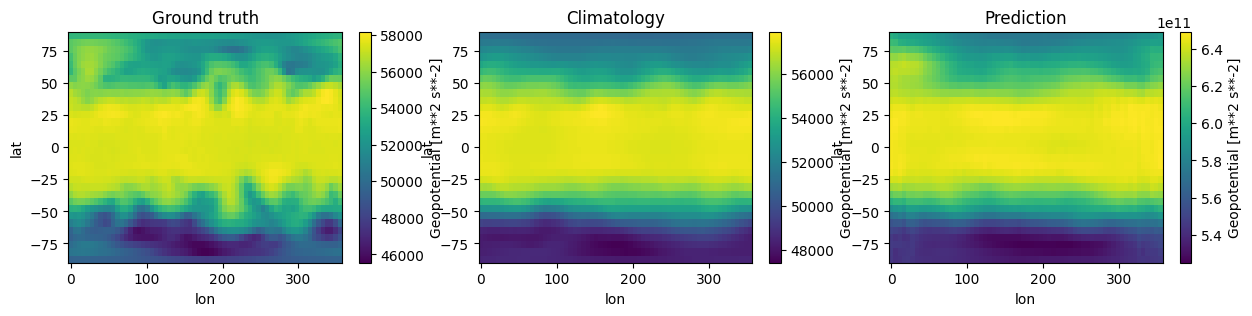

In [33]:
# Note first you need to modify your predictions so they are an xarray instead of a numpy array
# This way you can access the latitude, longitude and time for each point in the array

# We do this by taking a copy of the original z500 object which has the correct time, 
# latitude and longitude, and replacing the data in this array with the predictions
pred_xarray = z500.z.sel(time=test_years).isel(time=slice(lead_time_steps, None)).copy()
pred_xarray.data = pred_test

import matplotlib.pyplot as plt

t = xr.DataArray(np.datetime64('2017-10-01T00'))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

z500.z.sel(time=t).plot(ax=ax1)
ax1.set_title('Ground truth')

clim.z.sel(dayofyear=t.dt.dayofyear).plot(ax=ax2)
ax2.set_title('Climatology')

pred_xarray.sel(time=t).plot(ax=ax3)
ax3.set_title('Prediction')